# Analyse Exploratoire de Données (EDA)

In [58]:
%matplotlib inline
import os
import pandas as pd
import numpy as np
import seaborn as sns
import ydata_profiling
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer, StandardScaler

extract_path = './AI_Project_Data'

## Import des données

In [59]:
csv_employee_survey_data = os.path.join(extract_path, 'employee_survey_data.csv')
csv_manager_survey_data = os.path.join(extract_path, 'manager_survey_data.csv')
csv_general_data = os.path.join(extract_path, 'general_data.csv')
csv_out_time = os.path.join(extract_path, 'out_time.csv')
csv_in_time = os.path.join(extract_path, 'in_time.csv')

employee_survey_df = pd.read_csv(csv_employee_survey_data)
manager_survey_df = pd.read_csv(csv_manager_survey_data)
general_df = pd.read_csv(csv_general_data)
out_time_df = pd.read_csv(csv_out_time)
in_time_df = pd.read_csv(csv_in_time)

# init empty dataframe
work_info = pd.DataFrame()

## Nettoyage de données

### Valeurs dupliquées

In [60]:
work_info.duplicated().sum()

np.int64(0)

### Valeurs constantes

In [61]:
def remove_constant_columns(df):
    return df.loc[:, df.nunique() > 1]

### Valeurs manquantes

In [62]:
def fill_categorical_na(df):
    categorical_cols = df.select_dtypes(include=['object', 'category']).columns
    if len(categorical_cols) == 0:
        return df

    categorical_imputer = SimpleImputer(strategy='most_frequent')
    
    df.loc[:, categorical_cols] = categorical_imputer.fit_transform(df[categorical_cols])
    
    return df

In [63]:
def fill_numeric_na(df):
    for col in df.select_dtypes(include=['number', 'float64']).columns:
        median_value = df[col].median()
        df.loc[:, col] = df[col].fillna(round(median_value))
    return df

In [64]:
def fill_total_working_years(df):
    if 'TotalWorkingYears' in df.columns and 'YearsAtCompany' in df.columns:
        df.loc[:, 'TotalWorkingYears'] = df['TotalWorkingYears'].fillna(df['YearsAtCompany'])
    return df

### Type des valeurs

#### Simplification des types

In [65]:
def simplify_numeric_columns(df):
    df = df.apply(lambda col: col.astype(int) if col.dtype == 'float64' and col.dropna().mod(1).eq(0).all() else col)
    return df

#### Conversion des types `object` en valeurs numériques

In [66]:
def transform_attrition_to_bool(df):
    if 'Attrition' in df.columns:
        df.loc[:, 'Attrition'] = df['Attrition'].map({'Yes': True, 'No': False})
    return df

#### Gestion des fichiers contenant les horaires d'entrée et sortie des salariés

In [67]:
def reverse_and_merge(df):
    in_time_melted = in_time_df.melt(id_vars=['Unnamed: 0'], var_name='date', value_name='arrival_time')
    out_time_melted = out_time_df.melt(id_vars=['Unnamed: 0'], var_name='date', value_name='departure_time')

    # Renommer la colonne EmployeeID
    in_time_melted.rename(columns={'Unnamed: 0': 'EmployeeID'}, inplace=True)
    out_time_melted.rename(columns={'Unnamed: 0': 'EmployeeID'}, inplace=True)

    # Fusionner les deux DataFrames sur 'id' et 'date'
    merged_clock_in = pd.merge(in_time_melted, out_time_melted, on=['EmployeeID', 'date'], how='outer')
    return merged_clock_in

In [68]:
def generate_work_column(df):
    df['arrival_time'] = pd.to_datetime(df['arrival_time'])
    df['departure_time'] = pd.to_datetime(df['departure_time'])

    # Calculer le temps travaillé (différence entre départ et arrivée)
    df['worked_time'] = df['departure_time'] - df['arrival_time']

    # Convertir en heures pour avoir un format lisible
    df['worked_hours'] = df['worked_time'].dt.total_seconds() / 3600

    # Trier par id et date
    df.sort_values(by=['EmployeeID', 'date'], inplace=True)

    # Moyenne de la durée de travail par jour pour chaque employé
    mean_worked_hours = df.groupby('EmployeeID')['worked_hours'].mean()

    # Nombre total d'heures travaillées par employé
    total_worked_hours = df.groupby('EmployeeID')['worked_hours'].sum()

    # Nombre de jours ou le worked_hours est non nul
    worked_days = df[df['worked_hours'] > 0].groupby('EmployeeID')['worked_hours'].count()

    # Faire un data frame avec ces 3 informations pour chaque employé avec l'EmployeeID comme index
    work_info = pd.concat([mean_worked_hours, total_worked_hours, worked_days], axis=1)
    work_info.columns = ['mean_worked_hours', 'total_worked_hours', 'worked_days']
    return work_info

In [69]:
def employee_survey_to_cat(df):
    df['EnvironmentSatisfaction'] = df['EnvironmentSatisfaction'].replace({1: 'Poor', 2: 'Fair', 3: 'Good', 4: 'Excellent'})
    df['JobSatisfaction'] = df['JobSatisfaction'].replace({1: 'Dissatisfied', 2: 'Neutral', 3: 'Satisfied', 4: 'Very Satisfied'})
    df['WorkLifeBalance'] = df['WorkLifeBalance'].replace({1: 'Poor', 2: 'Average', 3: 'Good', 4: 'Excellent'})
    return df

In [70]:
def manager_survey_to_cat(df):
    df['JobInvolvement'] = df['JobInvolvement'].replace({1: 'Not Engaged', 2: 'Moderately Engaged', 3: 'Highly Engaged', 4: 'Fully Committed'})
    df['PerformanceRating'] = df['PerformanceRating'].replace({1: 'Poor', 2: 'Fair', 3: 'Good', 4: 'Outstanding'})
    return df

In [71]:
def general_to_cat(df):
    df['Education'] = df['Education'].replace({
        1: 'HighSchool', 
        2: 'Associate', 
        3: 'Bachelor', 
        4: 'Master', 
        5: 'PhD'
    })
    df['StockOptionLevel'] = df['StockOptionLevel'].replace({  
        0: 'None',  
        1: 'Low',  
        2: 'Medium',  
        3: 'High'  
    })
    return df

### Pipeline

In [72]:
default_preprocessor = Pipeline([
    ('remove_constants', FunctionTransformer(remove_constant_columns, validate=False)),
    ('fill_categorical_na', FunctionTransformer(fill_categorical_na, validate=False)),
    ('fill_numeric_na', FunctionTransformer(fill_numeric_na, validate=False)),
    ('simplify_numeric_columns', FunctionTransformer(simplify_numeric_columns, validate=False)),
])

employee_survey_preprocessor = Pipeline([
    ('default_preprocessor', default_preprocessor),
    ('employee_survey_to_cat', FunctionTransformer(employee_survey_to_cat, validate=False)),
])

manager_survey_preprocessor = Pipeline([
    ('default_preprocessor', default_preprocessor),
    ('manager_survey_to_cat', FunctionTransformer(manager_survey_to_cat, validate=False)),
])

general_preprocessor = Pipeline([
    ('fill_total_working_years', FunctionTransformer(fill_total_working_years, validate=False)),
    ('transform_attrition_to_bool', FunctionTransformer(transform_attrition_to_bool, validate=False)),
    ('general_to_cat', FunctionTransformer(general_to_cat, validate=False)),
    ('default_preprocessor', default_preprocessor),
])

work_info_preprocessor = Pipeline([
    ('reverse_and_merge', FunctionTransformer(reverse_and_merge, validate=False)),
    ('generate_work_column', FunctionTransformer(generate_work_column, validate=False)),
])

# Nettoyage des données
employee_survey_data = employee_survey_preprocessor.fit_transform(employee_survey_df)
manager_survey_data = manager_survey_preprocessor.fit_transform(manager_survey_df)
general_data = general_preprocessor.fit_transform(general_df)
work_info = work_info_preprocessor.fit_transform(work_info)

### Fusion des fichiers

In [73]:
clean_data = general_data.merge(employee_survey_data, on='EmployeeID').merge(manager_survey_data, on='EmployeeID').merge(work_info, on='EmployeeID')

clean_data = clean_data.drop(columns=['EmployeeID'])

In [74]:
clean_data_num = clean_data.select_dtypes(include=['number']).columns

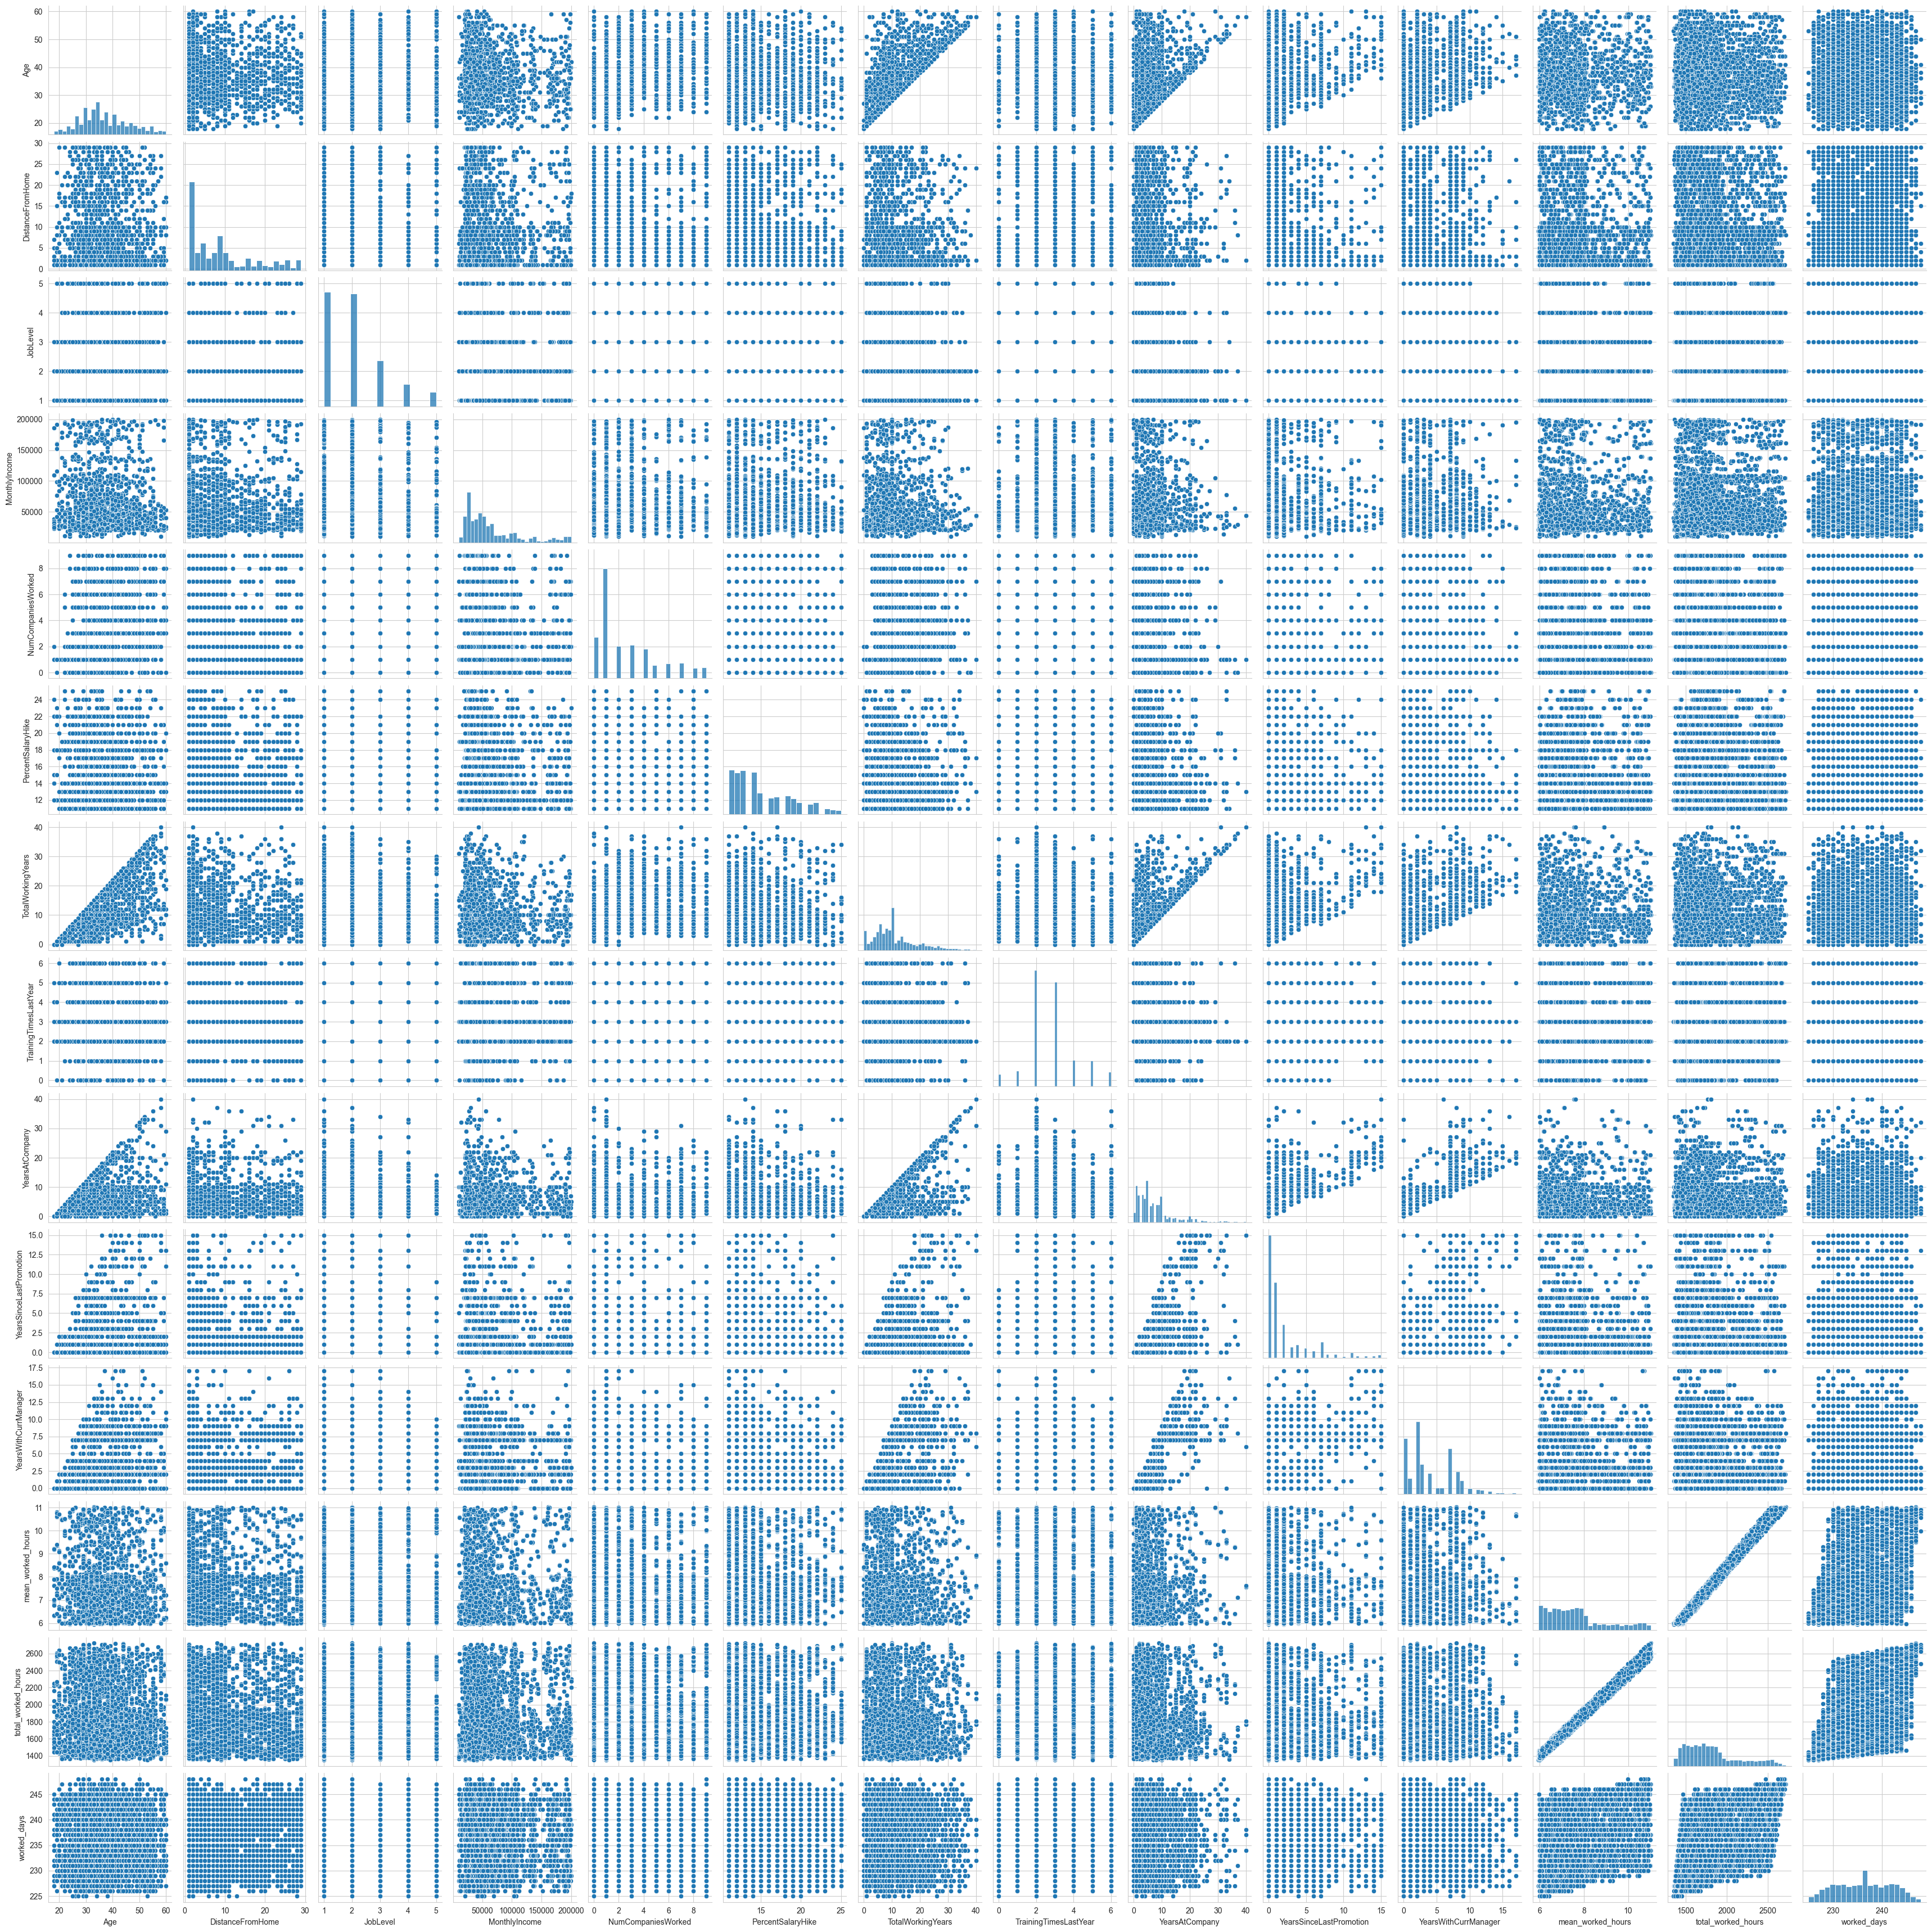

In [75]:
sns.pairplot(clean_data[clean_data_num])
plt.show()

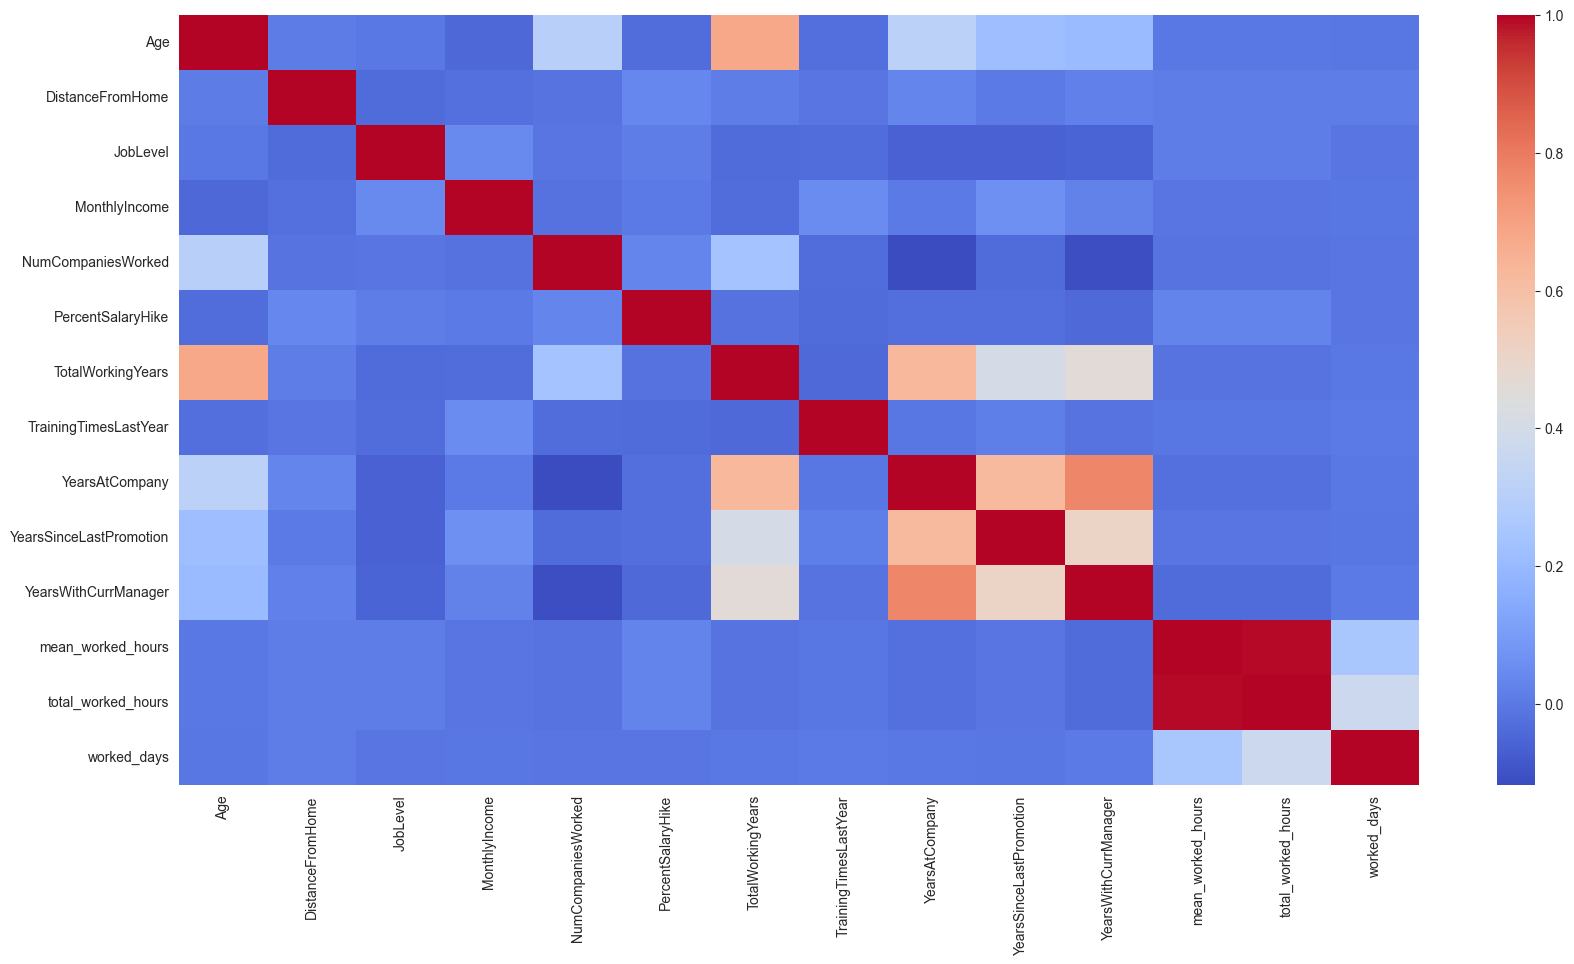

In [76]:
plt.figure(figsize=(20, 10))
sns.heatmap(clean_data[clean_data_num].corr(), cmap='coolwarm')

plt.show()

In [77]:
cat_columns = clean_data.select_dtypes(include=[object]).drop(columns=['Attrition'])

clean_data_cat = pd.get_dummies(cat_columns, dtype=float)

In [78]:
scaler = StandardScaler()

clean_data_num = pd.DataFrame(scaler.fit_transform(clean_data[clean_data_num]), columns=clean_data_num)

In [79]:
concat_data = pd.concat([clean_data_num, clean_data_cat, clean_data['Attrition']], axis=1)
concat_data

Age  DistanceFromHome  JobLevel  MonthlyIncome  NumCompaniesWorked  \
0     1.541369         -0.393938 -0.961486       1.405136           -0.678464   
1    -0.648668          0.099639 -0.961486      -0.491661           -1.079486   
2    -0.539166          0.963398  1.749610       2.725053           -0.678464   
3     0.117845         -0.887515  0.845911       0.386301            0.123580   
4    -0.539166          0.099639 -0.961486      -0.884109            0.524602   
...        ...               ...       ...            ...                 ...   
4405  0.555852         -0.517332 -0.961486      -0.100700            0.123580   
4406 -0.867672         -0.887515 -0.961486      -0.812504           -0.277442   
4407 -1.305679          1.950552 -0.057788      -0.595138           -1.079486   
4408  0.555852          1.086793 -0.961486      -0.872210           -1.079486   
4409  0.336849          2.320735 -0.057788      -0.219901           -1.079486   

      PercentSalaryHike  TotalWorkingYears  TrainingTimesLastYear  \
0             -1.150554          -1.320847               2.483396   
1              2.129306          -0.678145               0.155707   
2             -0.057267          -0.806686              -0.620189   
3             -1.150554           0.221637               1.707500   
4             -0.877232          -0.292524              -0.620189   
...                 ...                ...                    ...   
4405           0.489376          -0.163984               1.707500   
4406          -0.057267          -0.163984              -0.620189   
4407           1.309341          -0.806686               0.931603   
4408          -0.330589          -0.163984              -0.620189   
4409          -0.877232           1.249960               2.483396   

      YearsAtCompany  YearsSinceLastPromotion  ...  WorkLifeBalance_Excellent  \
0          -0.981014                -0.679146  ...                        0.0   
1          -0.327893                -0.368715  ...                        1.0   
2          -0.327893                -0.679146  ...                        0.0   
3           0.161947                 1.493867  ...                        0.0   
4          -0.164613                -0.679146  ...                        0.0   
...              ...                      ...  ...                        ...   
4405       -0.654454                -0.679146  ...                        0.0   
4406       -0.654454                -0.679146  ...                        0.0   
4407       -0.491174                -0.368715  ...                        0.0   
4408        0.325228                 1.493867  ...                        0.0   
4409        2.284590                 0.252146  ...                        0.0   

      WorkLifeBalance_Good  WorkLifeBalance_Poor  \
0                      0.0                   0.0   
1                      0.0                   0.0   
2                      0.0                   1.0   
3                      1.0                   0.0   
4                      1.0                   0.0   
...                    ...                   ...   
4405                   1.0                   0.0   
4406                   1.0                   0.0   
4407                   1.0                   0.0   
4408                   1.0                   0.0   
4409                   1.0                   0.0   

      JobInvolvement_Fully Committed  JobInvolvement_Highly Engaged  \
0                                0.0                            1.0   
1                                0.0                            0.0   
2                                0.0                            1.0   
3                                0.0                            0.0   
4                                0.0                            1.0   
...                              ...                            ...   
4405                             0.0                            1.0   
4406                             0.0       

## Analyse

In [80]:
df_true = concat_data[concat_data['Attrition'] == True]
df_false = concat_data[concat_data['Attrition'] == False]


min_count = min(len(df_true), len(df_false))

df_true_sampled = df_true.sample(n=min_count, random_state=42)
df_false_sampled = df_false.sample(n=min_count, random_state=42)


full_data = pd.concat([df_true_sampled, df_false_sampled])
full_data['Attrition'].value_counts()

Attrition
True     711
False    711
Name: count, dtype: int64

### YDataProfiling : résumé des différents graphiques

In [81]:
# final_data_report = ydata_profiling.ProfileReport(full_data, title='Full Data')
# final_data_report.to_notebook_iframe()
# TODO : enlever le commentaire

## Exportation du dataset modifié

In [82]:
full_data.to_csv(os.path.join(extract_path, 'cleaned_data.csv'), index=False)

## Sélection des caractéristiques ayant le plus d'impact sur le taux d'attrition

In [83]:
from sklearn.feature_selection import VarianceThreshold, SelectFromModel, RFE
from sklearn.ensemble import RandomForestClassifier
import numpy as np
import pandas as pd
from collections import defaultdict

def compare_feature_selection_methods(X, y, k_features):
    # Dictionnaire pour stocker les features sélectionnées par chaque méthode
    selected_features = defaultdict(list)
    
    # VarianceThreshold
    selector = VarianceThreshold(threshold=0.5)
    selector.fit_transform(X)
    selected_features['VarianceThreshold'] = list(X.columns[selector.get_support()])

    selector = SelectFromModel(RandomForestClassifier(n_estimators=100))
    selector.fit_transform(X, y)
    selected_features['SelectFromModel'] = list(X.columns[selector.get_support()])
    
    # RFE
    selector = RFE(RandomForestClassifier(n_estimators=100), 
                  n_features_to_select=k_features, 
                  step=1)
    selector.fit_transform(X, y)
    selected_features['RFE'] = list(X.columns[selector.get_support()])
    
    # Créer un DataFrame avec le nombre maximal de caractéristiques
    max_features = max(len(features) for features in selected_features.values())
    
    # Remplir avec None pour avoir des colonnes de même longueur
    for method in selected_features:
        selected_features[method].extend([None] * (max_features - len(selected_features[method])))
    
    # Créer le DataFrame final
    features_table = pd.DataFrame(selected_features)
    
    # Ajouter des statistiques sur les features sélectionnées
    print("\nNombre de caractéristiques sélectionnées par méthode:")
    for method in selected_features:
        count = sum(1 for x in selected_features[method] if x is not None)
        print(f"{method}: {count} features")
    
    return features_table

In [84]:
# Utilisation
X = full_data.drop(columns=['Attrition'])
y = full_data['Attrition'].astype(int)

features_table = compare_feature_selection_methods(X, y, k_features=15)
print("\nTableau des caractéristiques sélectionnées:")
features_table


Nombre de caractéristiques sélectionnées par méthode:
VarianceThreshold: 14 features
SelectFromModel: 16 features
RFE: 15 features

Tableau des caractéristiques sélectionnées:


VarianceThreshold               SelectFromModel  \
0                       Age                           Age   
1          DistanceFromHome              DistanceFromHome   
2                  JobLevel                      JobLevel   
3             MonthlyIncome                 MonthlyIncome   
4        NumCompaniesWorked            NumCompaniesWorked   
5         PercentSalaryHike             PercentSalaryHike   
6         TotalWorkingYears             TotalWorkingYears   
7     TrainingTimesLastYear         TrainingTimesLastYear   
8            YearsAtCompany                YearsAtCompany   
9   YearsSinceLastPromotion       YearsSinceLastPromotion   
10     YearsWithCurrManager          YearsWithCurrManager   
11        mean_worked_hours             mean_worked_hours   
12       total_worked_hours            total_worked_hours   
13              worked_days                   worked_days   
14                     None          MaritalStatus_Single   
15                     None  EnvironmentSatisfaction_Poor   

                        RFE  
0                       Age  
1          DistanceFromHome  
2                  JobLevel  
3             MonthlyIncome  
4        NumCompaniesWorked  
5         PercentSalaryHike  
6         TotalWorkingYears  
7     TrainingTimesLastYear  
8            YearsAtCompany  
9   YearsSinceLastPromotion  
10     YearsWithCurrManager  
11        mean_worked_hours  
12       total_worked_hours  
13              worked_days  
14     MaritalStatus_Single  
15                     None

# Sélectionner le modèle le plus performant pour prédire l'attrition

In [85]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
import matplotlib.pyplot as plt
import missingno as msno
import numpy as np
import pandas as pd 
import seaborn as sns

from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC 
from sklearn.linear_model import LogisticRegression


# Load the data
filename = './AI_Project_Data/cleaned_data.csv'
employee_data = pd.read_csv(filename)

# Displaying data.head() to see the first 5 rows of the data
employee_data.head()

Age  DistanceFromHome  JobLevel  MonthlyIncome  NumCompaniesWorked  \
0 -0.539166         -0.270544 -0.057788      -0.680979            2.128690   
1 -1.524683          0.346427 -0.057788       0.217168           -0.678464   
2  0.993860         -1.010909 -0.057788       0.682284           -0.678464   
3 -0.867672          2.444129 -0.961486      -0.891546           -0.678464   
4 -0.320163          0.716610 -0.057788       0.416473           -0.277442   

   PercentSalaryHike  TotalWorkingYears  TrainingTimesLastYear  \
0           1.855984          -0.678145               0.931603   
1          -0.330589          -1.063766              -0.620189   
2           1.855984          -0.292524              -2.171982   
3          -0.603911          -0.549605              -2.171982   
4          -0.603911          -0.421064              -0.620189   

   YearsAtCompany  YearsSinceLastPromotion  ...  WorkLifeBalance_Excellent  \
0       -0.491174                -0.368715  ...                        0.0   
1       -0.654454                -0.679146  ...                        0.0   
2        0.325228                 0.562576  ...                        0.0   
3       -0.001333                -0.679146  ...                        0.0   
4       -0.491174                -0.368715  ...                        0.0   

   WorkLifeBalance_Good  WorkLifeBalance_Poor  JobInvolvement_Fully Committed  \
0                   1.0                   0.0                             0.0   
1                   1.0                   0.0                             0.0   
2                   1.0                   0.0                             0.0   
3                   0.0                   0.0                             0.0   
4                   1.0                   0.0                             0.0   

   JobInvolvement_Highly Engaged  JobInvolvement_Moderately Engaged  \
0                            0.0                                1.0   
1                            1.0                                0.0   
2                            1.0                                0.0   
3                            1.0                                0.0   
4                            0.0                                0.0   

   JobInvolvement_Not Engaged  PerformanceRating_Good  \
0                         0.0                     0.0   
1                         0.0                     1.0   
2                         0.0                     0.0   
3                         0.0                     1.0   
4                         1.0                     1.0   

   PerformanceRating_Outstanding  Attrition  
0                            1.0       True  
1                            0.0       True  
2                            1.0       True  
3                            0.0       True  
4                            0.0       True  

[5 rows x 68 columns]

## Prédiction des valeurs d'attrition

### Séparation du dataset en plusieurs échantillons pour la validation croisée

In [86]:
from sklearn.model_selection import StratifiedShuffleSplit
employee_df = employee_data.copy()

y = employee_df["Attrition"]
X = employee_df.drop(columns=["Attrition"])

split = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=42)

models = {
    "LogisticRegression": LogisticRegression(random_state=42),
    "SVC": SVC(probability=True, random_state=42),
    "RandomForest": RandomForestClassifier(random_state=42), 
    "DecisionTreeClassifier": DecisionTreeClassifier(random_state=42),
}

In [87]:
# Initialisation des dictionnaires pour stocker les scores
scores = []
predictions = {}
metrics = {
    'precision': {name: [] for name in models.keys()},
    'recall': {name: [] for name in models.keys()},
    'f1': {name: [] for name in models.keys()},
    'auc': {name: [] for name in models.keys()},
    'accuracy': {name: [] for name in models.keys()}
}

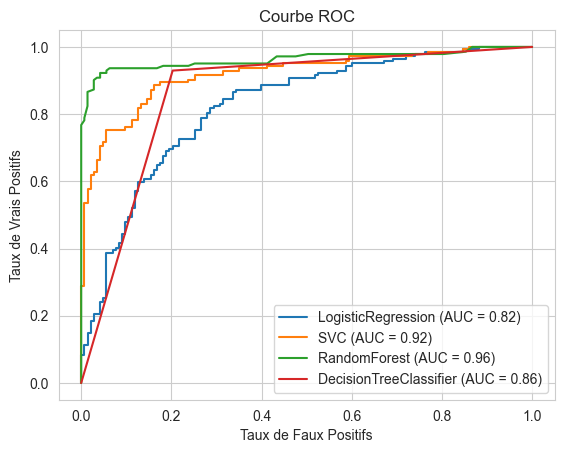

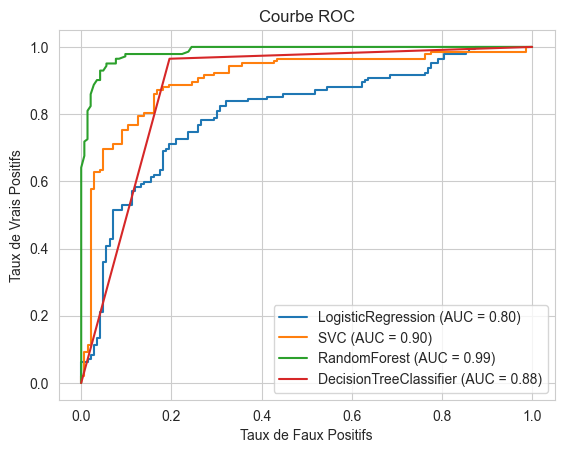

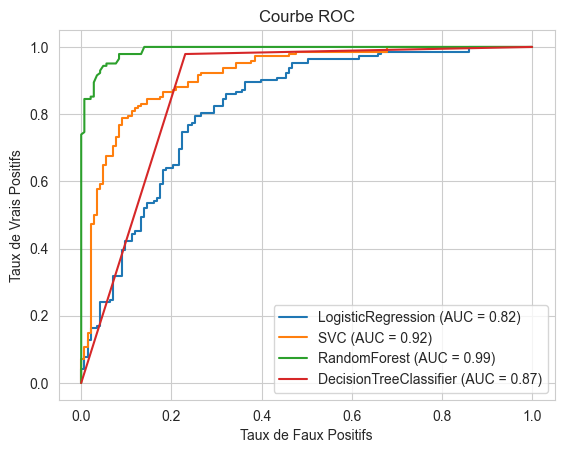

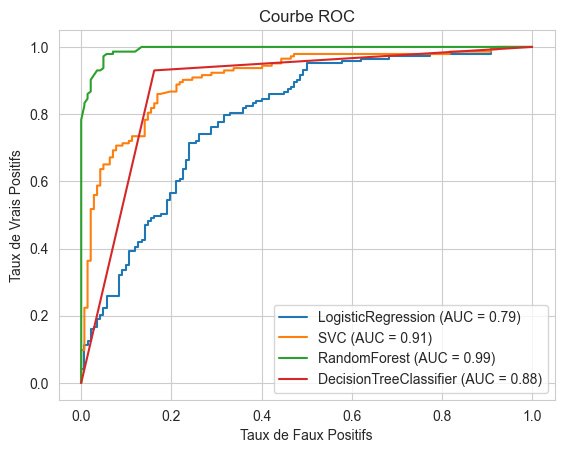

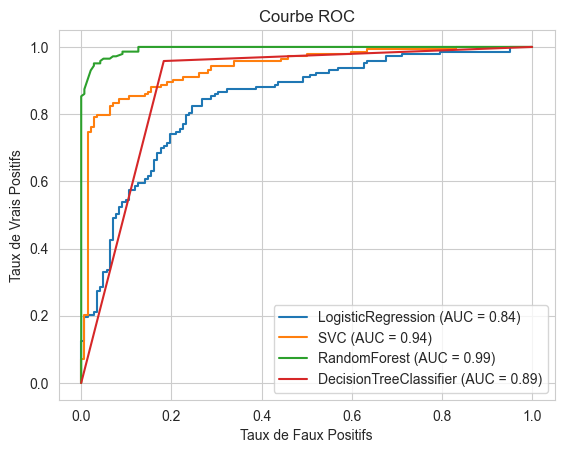

In [88]:
# Évaluation des modèles
from sklearn.metrics import roc_curve

for train_index, test_index in split.split(X, y):
    X_train, X_test = X.loc[train_index], X.loc[test_index]
    y_train, y_test = y.loc[train_index], y.loc[test_index]
    
    for name, model in models.items():
        # Prédictions
        model.fit(X_train, y_train)
        predictions[name] = model.predict(X_test)    
        y_pred = model.predict(X_test)
        y_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else None
        
        # Calcul des métriques
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        auc = roc_auc_score(y_test, y_proba) if y_proba is not None else np.nan
        fpr, tpr, _ = roc_curve(y_test, y_proba) if y_proba is not None else (None, None, None)
        accuracy = accuracy_score(y_test, y_pred)
        
        plt.plot(fpr, tpr, label=f"{name} (AUC = {auc:.2f})")
        
        # Stockage des métriques
        metrics['precision'][name].append(precision)
        metrics['recall'][name].append(recall)
        metrics['f1'][name].append(f1)
        metrics['auc'][name].append(auc)
        metrics['accuracy'][name].append(accuracy)
        # Ajout des scores dans le DataFrame final
        scores.append({
            'Model': name,
            'Precision': precision,
            'Recall': recall,
            'F1 Score': f1,
            'Accuracy': accuracy,
            'AUC': auc
        })
    plt.xlabel("Taux de Faux Positifs")
    plt.ylabel("Taux de Vrais Positifs")
    plt.title("Courbe ROC")
    plt.legend()
    plt.show()
        


In [89]:
scores_df = pd.DataFrame(scores)
scores_df_mean = scores_df.groupby('Model').mean()
scores_df_std = scores_df.groupby('Model').std()
scores_df_mean = scores_df_mean.sort_values(['F1 Score', 'Precision', 'Recall', 'Accuracy'], ascending=False) # TODO : change order
scores_df_std = scores_df_std.sort_values(['F1 Score', 'Precision', 'Recall', 'Accuracy'], ascending=True) # TODO : change order

print('Mean Scores')
print(scores_df_mean)
print('_'*50)
print('Standard Deviation')
print(scores_df_std)

Mean Scores
                        Precision    Recall  F1 Score  Accuracy       AUC
Model                                                                    
RandomForest             0.898292  0.976076  0.935336  0.932632  0.985526
DecisionTreeClassifier   0.830275  0.952270  0.886841  0.878596  0.878691
SVC                      0.844839  0.849641  0.846489  0.846316  0.916926
LogisticRegression       0.747443  0.769585  0.757916  0.755088  0.815375
__________________________________________________
Standard Deviation
                        Precision    Recall  F1 Score  Accuracy       AUC
Model                                                                    
RandomForest             0.013467  0.023683  0.009007  0.008737  0.012909
DecisionTreeClassifier   0.017315  0.021826  0.009457  0.010109  0.009939
SVC                      0.022738  0.039386  0.016584  0.014339  0.012972
LogisticRegression       0.015237  0.048608  0.028468  0.023849  0.018397


### Analyse des temps d'entrainement et de prediction

In [90]:
import time

training_times = []
prediction_times = []

for name, model in models.items():
    
    # Measure training time
    start_time = time.time()
    model.fit(X_train, y_train)
    end_time = time.time()
    training_times.append(end_time - start_time)
    
    # Measure prediction time
    start_time = time.time()
    model.predict(X_test)
    end_time = time.time()
    prediction_times.append(end_time - start_time)

# Create DataFrame to store times
time_df = pd.DataFrame({
    'Model': models.keys(),
    'Training Time (s)': training_times,
    'Prediction Time (s)': prediction_times
})

time_df = time_df.sort_values(['Prediction Time (s)', 'Training Time (s)'], ascending=True) # TODO : change order
print(time_df)

                    Model  Training Time (s)  Prediction Time (s)
3  DecisionTreeClassifier           0.008245             0.000733
0      LogisticRegression           0.008200             0.001127
2            RandomForest           0.132120             0.005729
1                     SVC           0.171011             0.016524


### Analyse de l'importance des différentes variables du dataset sur la prédiction

In [91]:
X.head()

Age  DistanceFromHome  JobLevel  MonthlyIncome  NumCompaniesWorked  \
0 -0.539166         -0.270544 -0.057788      -0.680979            2.128690   
1 -1.524683          0.346427 -0.057788       0.217168           -0.678464   
2  0.993860         -1.010909 -0.057788       0.682284           -0.678464   
3 -0.867672          2.444129 -0.961486      -0.891546           -0.678464   
4 -0.320163          0.716610 -0.057788       0.416473           -0.277442   

   PercentSalaryHike  TotalWorkingYears  TrainingTimesLastYear  \
0           1.855984          -0.678145               0.931603   
1          -0.330589          -1.063766              -0.620189   
2           1.855984          -0.292524              -2.171982   
3          -0.603911          -0.549605              -2.171982   
4          -0.603911          -0.421064              -0.620189   

   YearsAtCompany  YearsSinceLastPromotion  ...  WorkLifeBalance_Average  \
0       -0.491174                -0.368715  ...                      0.0   
1       -0.654454                -0.679146  ...                      0.0   
2        0.325228                 0.562576  ...                      0.0   
3       -0.001333                -0.679146  ...                      1.0   
4       -0.491174                -0.368715  ...                      0.0   

   WorkLifeBalance_Excellent  WorkLifeBalance_Good  WorkLifeBalance_Poor  \
0                        0.0                   1.0                   0.0   
1                        0.0                   1.0                   0.0   
2                        0.0                   1.0                   0.0   
3                        0.0                   0.0                   0.0   
4                        0.0                   1.0                   0.0   

   JobInvolvement_Fully Committed  JobInvolvement_Highly Engaged  \
0                             0.0                            0.0   
1                             0.0                            1.0   
2                             0.0                            1.0   
3                             0.0                            1.0   
4                             0.0                            0.0   

   JobInvolvement_Moderately Engaged  JobInvolvement_Not Engaged  \
0                                1.0                         0.0   
1                                0.0                         0.0   
2                                0.0                         0.0   
3                                0.0                         0.0   
4                                0.0                         1.0   

   PerformanceRating_Good  PerformanceRating_Outstanding  
0                     0.0                            1.0  
1                     1.0                            0.0  
2                     0.0                            1.0  
3                     1.0                            0.0  
4                     1.0                            0.0  

[5 rows x 67 columns]

In [92]:
from sklearn.inspection import permutation_importance

def get_feature_importance(model, X, y, model_name):
    feature_names = X.columns
    importance_dict = {}
    
    if model_name == "RandomForest" or model_name == "DecisionTreeClassifier":
        # Ces modèles ont feature_importances_ natif
        importance_dict = dict(zip(feature_names, model.feature_importances_))
        
    elif model_name == "LogisticRegression":
        # Pour la régression logistique, on utilise les coefficients
        if len(model.classes_) == 2:  # Classification binaire
            importance_dict = dict(zip(feature_names, np.abs(model.coef_[0])))
        else:  # Classification multi-classe
            # Moyenne des valeurs absolues des coefficients pour chaque classe
            importance_dict = dict(zip(feature_names, np.mean(np.abs(model.coef_), axis=0)))
            
    elif model_name == "SVC":
        # Pour SVC, on utilise permutation_importance car pas d'importance native
        result = permutation_importance(model, X, y, n_repeats=10, random_state=42)
        importance_dict = dict(zip(feature_names, result.importances_mean))
    
    return importance_dict

def plot_feature_importance(importance_dict, model_name, top_n=50):

    plt.figure(figsize=(12, 10))
    
    # Conversion en DataFrame pour faciliter la manipulation
    df_importance = pd.DataFrame({
        'feature': importance_dict.keys(),
        'importance': importance_dict.values()
    })
    
    # Tri par importance décroissante et sélection des top_n features
    df_importance = df_importance.sort_values('importance', ascending=True).tail(top_n)
    
    # Création du graphique
    sns.barplot(data=df_importance, x='importance', y='feature', palette="viridis")
    
    plt.title(f'Top {top_n} Features Importance - {model_name}')
    plt.xlabel('Importance')
    plt.ylabel('Features')
    
    # Ajout des valeurs sur les barres
    for i, v in enumerate(df_importance['importance']):
        plt.text(v, i, f'{v:.3f}', va='center')
    
    plt.tight_layout()
    plt.show()


LogisticRegression Feature Importance:


/var/folders/2g/j9vx62552g15xf51dnw6xt1m0000gr/T/ipykernel_518/4123114772.py:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_importance, x='importance', y='feature', palette="viridis")


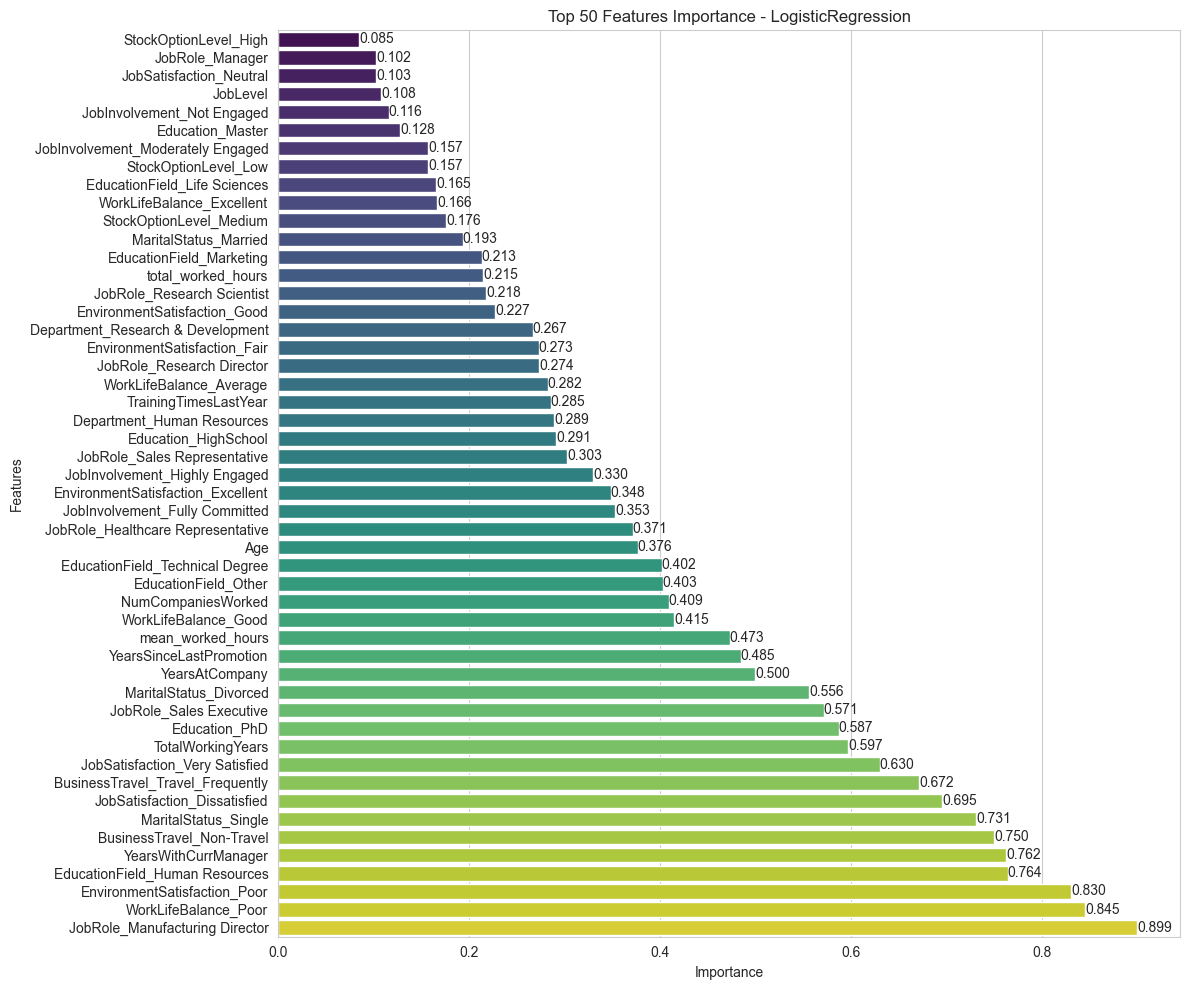


SVC Feature Importance:


/var/folders/2g/j9vx62552g15xf51dnw6xt1m0000gr/T/ipykernel_518/4123114772.py:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_importance, x='importance', y='feature', palette="viridis")


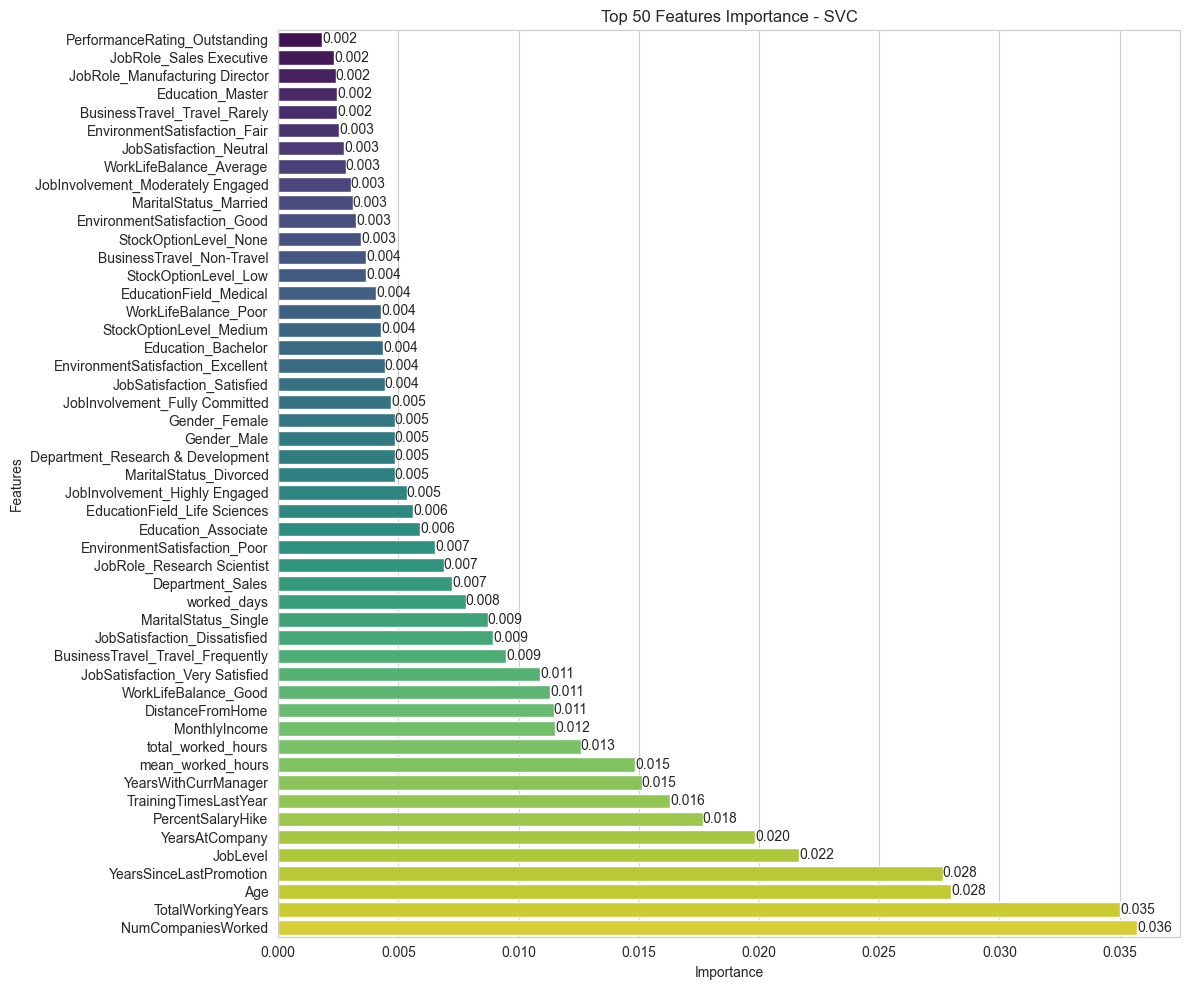


RandomForest Feature Importance:


/var/folders/2g/j9vx62552g15xf51dnw6xt1m0000gr/T/ipykernel_518/4123114772.py:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_importance, x='importance', y='feature', palette="viridis")


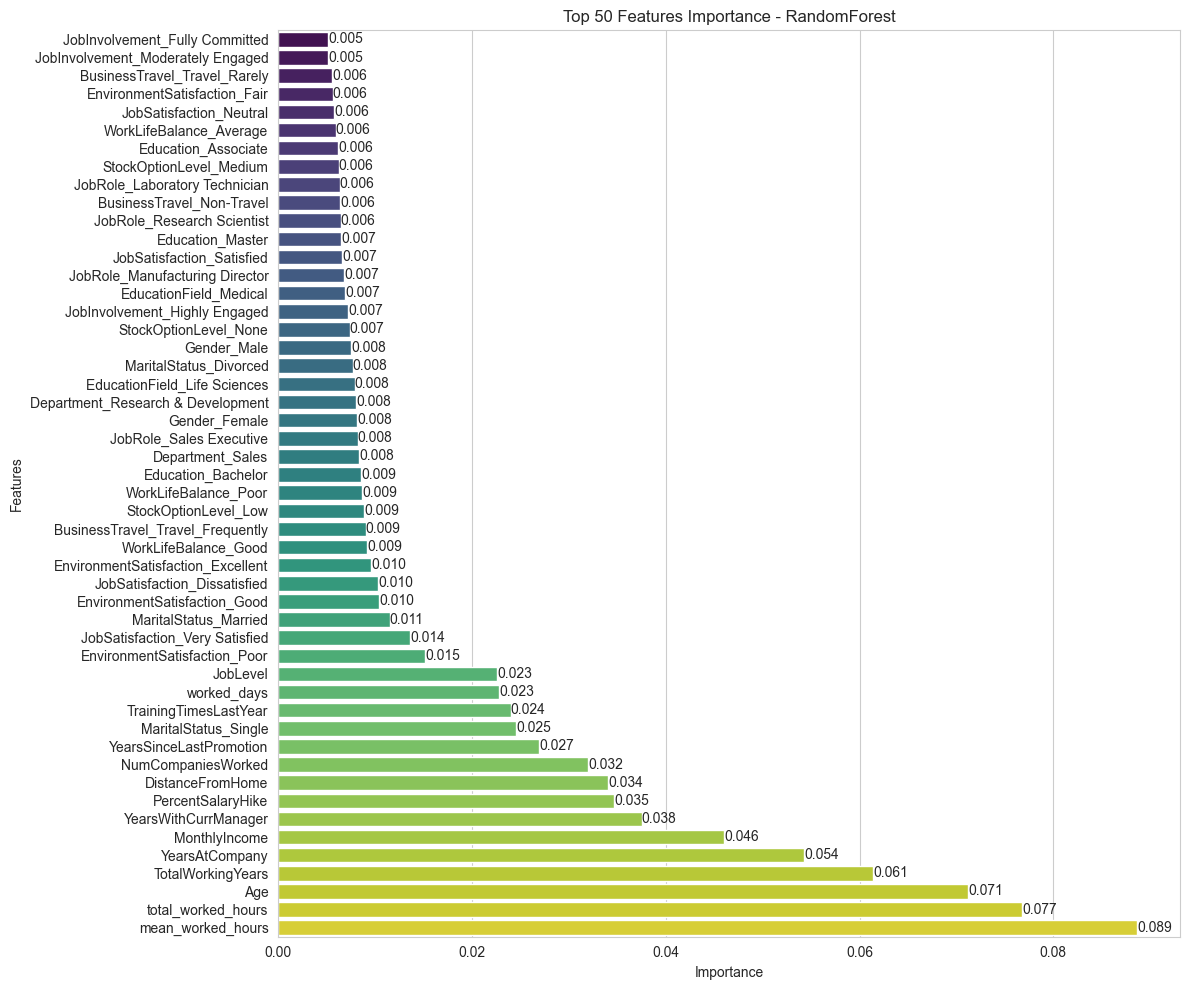


DecisionTreeClassifier Feature Importance:


/var/folders/2g/j9vx62552g15xf51dnw6xt1m0000gr/T/ipykernel_518/4123114772.py:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_importance, x='importance', y='feature', palette="viridis")


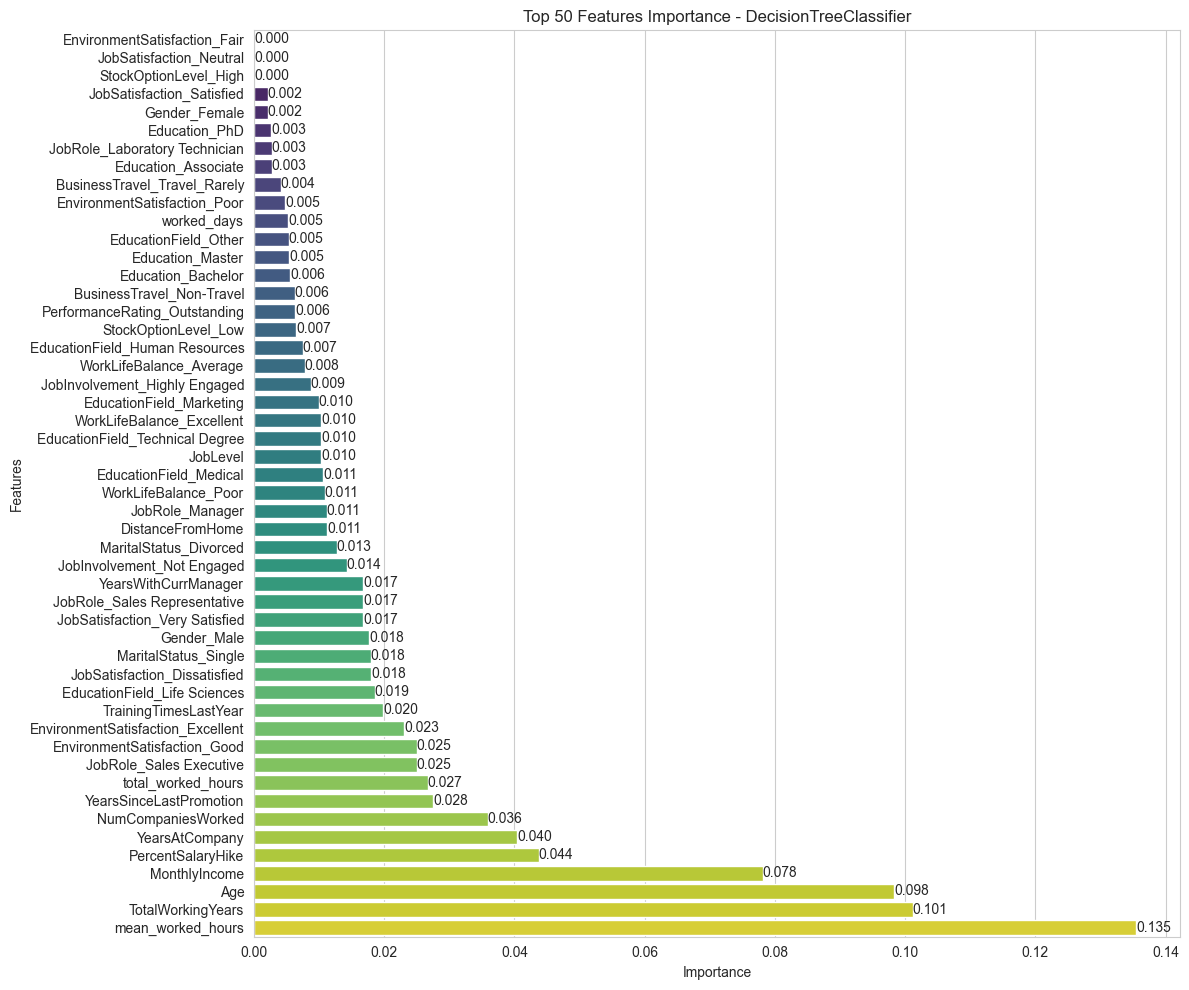

In [93]:
for model_name, model in models.items():
    print(f"\n{model_name} Feature Importance:")
    # Entraînement du modèle
    model.fit(X, y)
    
    # Calcul et affichage des importances
    importance_dict = get_feature_importance(model, X, y, model_name)
    
    # Visualisation
    plot_feature_importance(importance_dict, model_name)

### Optimiser le meilleur modèle

In [94]:
# hyperparameter tuning
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

svc_params_grid = {
    # Most important parameters
    'C': [0.1, 1, 10],
    'kernel': ['rbf', 'linear'],
    'gamma': ['scale', 'auto', 0.01],
    
    # Basic settings
    'class_weight': [None, 'balanced'],
    'random_state': [42],
    'probability': [True]
}

# creating model using GridSearchCV
SVC_model = GridSearchCV(
    estimator=SVC(probability=True),
    param_grid=svc_params_grid,
    cv=5,
    n_jobs=-1,
    scoring=['accuracy', 'f1', 'precision', 'recall', 'roc_auc'],
    refit='accuracy',
    verbose=0,
    error_score='raise',
    return_train_score=True
)

# Définition d'une grille simplifiée de paramètres
rf_params_grid = {
    # Paramètres essentiels
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'max_features': ['sqrt', 'log2'],
    
    # Paramètres de base
    'random_state': [42],
    'n_jobs': [-1],
    'class_weight': [None, 'balanced']
}

# Configuration du GridSearchCV avec des options avancées
RandomForest_model = GridSearchCV(
    estimator=RandomForestClassifier(),
    param_grid=rf_params_grid,
    cv=5,  # Validation croisée à 5 plis
    n_jobs=-1,  # Utilise tous les cœurs disponibles
    scoring=['accuracy', 'f1', 'precision', 'recall', 'roc_auc'],
    refit='accuracy',  # Réentraîne sur la meilleure métrique accuracy
    verbose=2,
    return_train_score=True,
    error_score='raise'
)

# model fitting
RandomForest_model.fit(X_train, y_train)
SVC_model.fit(X_train, y_train)

# getting best parameters
best_rf_model = RandomForest_model.best_estimator_
best_svc_model = SVC_model.best_estimator_

# displaying results
print("\nMeilleurs paramètres trouvés :")
print(f"\nRandomForest {RandomForest_model.best_params_}")
print(f"\nSVC {SVC_model.best_params_}")
print("\nMeilleur score de validation croisée:")
print(f"\nRandomForest {RandomForest_model.best_score_}")
print(f"\nSVC {SVC_model.best_score_}")


# displaying scores for metrics
rf_results = pd.DataFrame(RandomForest_model.cv_results_)
svc_results = pd.DataFrame(SVC_model.cv_results_)
print("\nRésultats détaillés pour la meilleure configuration:")
metrics = ['accuracy', 'f1', 'precision', 'recall', 'roc_auc']


Fitting 5 folds for each of 72 candidates, totalling 360 fits
[CV] END class_weight=None, max_depth=None, max_features=sqrt, min_samples_split=2, n_estimators=100, n_jobs=-1, random_state=42; total time=   0.2s
[CV] END class_weight=None, max_depth=None, max_features=sqrt, min_samples_split=2, n_estimators=100, n_jobs=-1, random_state=42; total time=   0.2s
[CV] END class_weight=None, max_depth=None, max_features=sqrt, min_samples_split=2, n_estimators=100, n_jobs=-1, random_state=42; total time=   0.2s
[CV] END class_weight=None, max_depth=None, max_features=sqrt, min_samples_split=2, n_estimators=100, n_jobs=-1, random_state=42; total time=   0.2s
[CV] END class_weight=None, max_depth=None, max_features=sqrt, min_samples_split=2, n_estimators=100, n_jobs=-1, random_state=42; total time=   0.2s
[CV] END class_weight=None, max_depth=None, max_features=sqrt, min_samples_split=2, n_estimators=200, n_jobs=-1, random_state=42; total time=   0.5s
[CV] END class_weight=None, max_depth=None, 

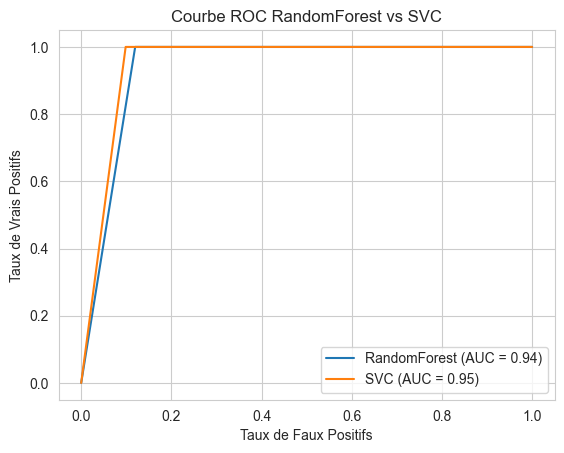

In [95]:
y_pred = best_rf_model.predict(X_test)
fpr, tpr, _ = roc_curve(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred)
plt.plot(fpr, tpr, label=f"RandomForest (AUC = {auc:.2f})")


y_pred = best_svc_model.predict(X_test)
fpr, tpr, _ = roc_curve(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred)
plt.plot(fpr, tpr, label=f"SVC (AUC = {auc:.2f})")


plt.xlabel("Taux de Faux Positifs")
plt.ylabel("Taux de Vrais Positifs")
plt.title("Courbe ROC RandomForest vs SVC")
plt.legend()
plt.show()

In [96]:
rf_results.head()

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0       0.148248      0.008560         0.070650        0.007964   
1       0.350824      0.035944         0.098770        0.010807   
2       0.504434      0.058610         0.122604        0.013416   
3       0.149397      0.024045         0.070885        0.012698   
4       0.385913      0.038733         0.112552        0.027475   

  param_class_weight param_max_depth param_max_features  \
0               None            None               sqrt   
1               None            None               sqrt   
2               None            None               sqrt   
3               None            None               sqrt   
4               None            None               sqrt   

   param_min_samples_split  param_n_estimators  param_n_jobs  ...  \
0                        2                 100            -1  ...   
1                        2                 200            -1  ...   
2                        2                 300            -1  ...   
3                        5                 100            -1  ...   
4                        5                 200            -1  ...   

   mean_test_roc_auc std_test_roc_auc  rank_test_roc_auc  \
0           0.976830         0.006785                 21   
1           0.979801         0.008058                 15   
2           0.979912         0.006983                 12   
3           0.970410         0.005881                 47   
4           0.973040         0.007486                 38   

   split0_train_roc_auc  split1_train_roc_auc  split2_train_roc_auc  \
0                   1.0                   1.0                   1.0   
1                   1.0                   1.0                   1.0   
2                   1.0                   1.0                   1.0   
3                   1.0                   1.0                   1.0   
4                   1.0                   1.0                   1.0   

   split3_train_roc_auc  split4_train_roc_auc  mean_train_roc_auc  \
0                   1.0                   1.0                 1.0   
1                   1.0                   1.0                 1.0   
2                   1.0                   1.0                 1.0   
3                   1.0                   1.0                 1.0   
4                   1.0                   1.0                 1.0   

   std_train_roc_auc  
0       4.965068e-17  
1       0.000000e+00  
2       0.000000e+00  
3       0.000000e+00  
4       0.000000e+00  

[5 rows x 87 columns]

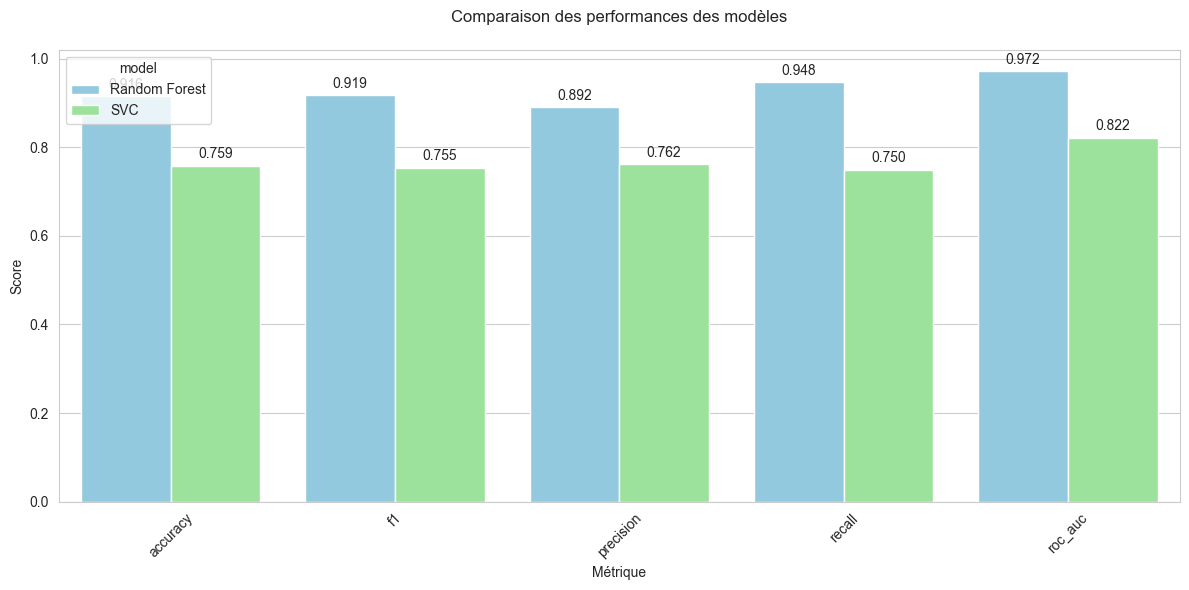

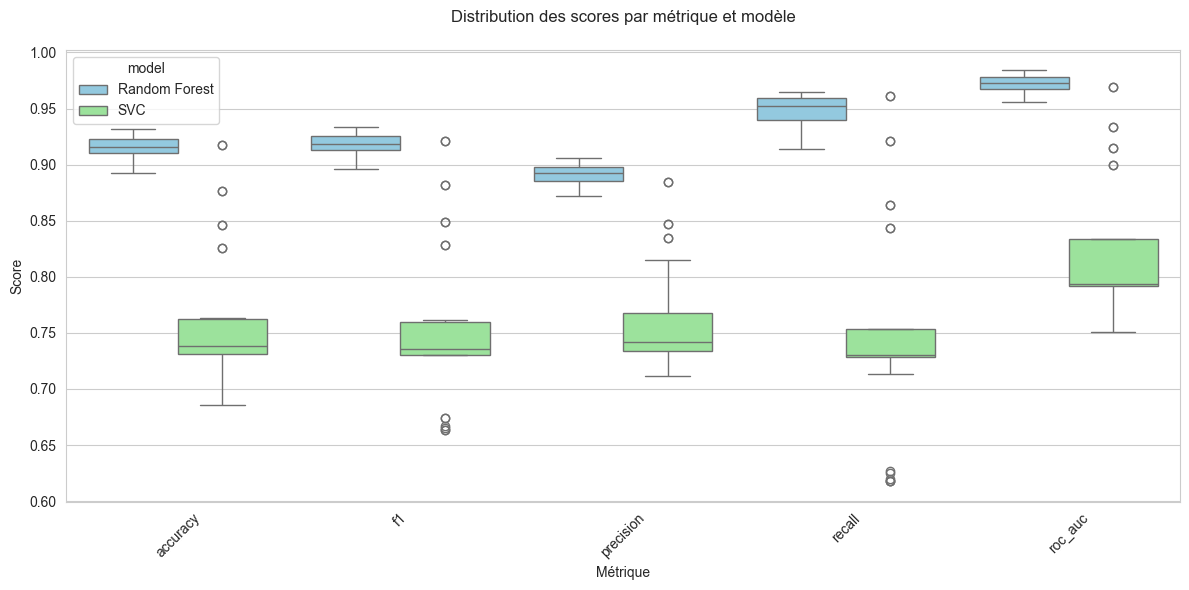

In [97]:
# Préparation des données pour la visualisation
def prepare_comparison_data(rf_results, svc_results, metrics):
    # Création d'un dataframe pour la comparaison
    comparison_data = []
    
    for metric in metrics:
        # Random Forest
        rf_scores = {
            'model': 'Random Forest',
            'metric': metric,
            'score': rf_results[f'mean_test_{metric}'].mean(),
            'std': rf_results[f'std_test_{metric}'].mean()
        }
        comparison_data.append(rf_scores)
        
        # SVC
        svc_scores = {
            'model': 'SVC',
            'metric': metric,
            'score': svc_results[f'mean_test_{metric}'].mean(),
            'std': svc_results[f'std_test_{metric}'].mean()
        }
        comparison_data.append(svc_scores)
    
    return pd.DataFrame(comparison_data)

# 1. Graphique comparatif des métriques
def plot_metrics_comparison(comparison_data):
    plt.figure(figsize=(12, 6))
    sns.set_style("whitegrid")
    
    # Création du barplot
    ax = sns.barplot(
        data=comparison_data,
        x='metric',
        y='score',
        hue='model',
        palette=['skyblue', 'lightgreen'],
        capsize=0.1
    )
    
    plt.title('Comparaison des performances des modèles', pad=20)
    plt.xlabel('Métrique')
    plt.ylabel('Score')
    plt.xticks(rotation=45)
    
    # Ajout des valeurs sur les barres
    for container in ax.containers:
        ax.bar_label(container, fmt='%.3f', padding=3)
    
    plt.tight_layout()
    plt.show()

# 2. Boxplot des distributions des scores
def plot_score_distributions(rf_results, svc_results, metrics):
    # Préparation des données pour le boxplot
    plot_data = []
    
    for metric in metrics:
        # Random Forest
        for score in rf_results[f'mean_test_{metric}']:
            plot_data.append({
                'model': 'Random Forest',
                'metric': metric,
                'score': score
            })
        
        # SVC
        for score in svc_results[f'mean_test_{metric}']:
            plot_data.append({
                'model': 'SVC',
                'metric': metric,
                'score': score
            })
    
    plot_df = pd.DataFrame(plot_data)
    
    # Création du boxplot
    plt.figure(figsize=(12, 6))
    sns.boxplot(
        data=plot_df,
        x='metric',
        y='score',
        hue='model',
        palette=['skyblue', 'lightgreen']
    )
    
    plt.title('Distribution des scores par métrique et modèle', pad=20)
    plt.xlabel('Métrique')
    plt.ylabel('Score')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Utilisation des fonctions
# Créer le DataFrame de comparaison
comparison_df = prepare_comparison_data(rf_results, svc_results, metrics)

# Générer les visualisations
plot_metrics_comparison(comparison_df)
plot_score_distributions(rf_results, svc_results, metrics)

In [98]:
for metric in metrics:
    mean_score = rf_results[f'mean_test_{metric}'].iloc[rf_results['rank_test_accuracy'].argmin()]
    std_score = rf_results[f'std_test_{metric}'].iloc[rf_results['rank_test_accuracy'].argmin()]
    print(f"RandomForest - {metric}: {mean_score:.3f} (+/- {std_score:.3f})")
    
    mean_score = svc_results[f'mean_test_{metric}'].iloc[svc_results['rank_test_accuracy'].argmin()]
    std_score = svc_results[f'std_test_{metric}'].iloc[svc_results['rank_test_accuracy'].argmin()]
    print(f"SVC - {metric}: {mean_score:.3f} (+/- {std_score:.3f})")

RandomForest - accuracy: 0.931 (+/- 0.019)
SVC - accuracy: 0.917 (+/- 0.033)
RandomForest - f1: 0.934 (+/- 0.017)
SVC - f1: 0.921 (+/- 0.031)
RandomForest - precision: 0.906 (+/- 0.024)
SVC - precision: 0.885 (+/- 0.040)
RandomForest - recall: 0.963 (+/- 0.013)
SVC - recall: 0.961 (+/- 0.026)
RandomForest - roc_auc: 0.981 (+/- 0.008)
SVC - roc_auc: 0.969 (+/- 0.014)
